In [2]:
import os
# Set up runtime to mimic an 8-core machine for pmap example below:
import os

flags = os.environ.get('XLA_FLAGS', '')
#os.environ['XLA_FLAGS'] = flags + "--xla_force_host_parallel_compilation=true --xla_force_host_platform_device_count=48"
# # Environment configuration
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


import jax
from openqdc.datasets import SpiceV2 as Spice

from physnetjax.data.datasets import process_in_memory
from physnetjax.models.model import EF
from physnetjax.training.training import train_model

# Constants
NATOMS = 110
# total number of samples, SpiceV2 = 2008628
NTRAIN = 100 #10_000_0 #00
NVALID = 100_0#00 # 0
DATA_KEYS = ("Z", "R", "E", "F", "N")
RANDOM_SEED = 42
BATCH_SIZE = 4


# JAX Configuration Check
def check_jax_configuration():
    devices = jax.local_devices()
    print("Devices:", devices)
    print("Default Backend:", jax.default_backend())
    print("All Devices:", jax.devices())


check_jax_configuration()


# Dataset preparation
def prepare_spice_dataset(
    dataset, subsample_size, max_atoms, ignore_indices=None, key=jax.random.PRNGKey(42)
):
    """Prepare the dataset by preprocessing and subsampling."""
    key = key[0] if len(key) > 1 else key
    indices = dataset.subsample(subsample_size, seed=key)
    if ignore_indices is not None:
        indices = [_ for _ in indices if _ not in ignore_indices]
    d = [ds[_] for _ in indices] # if ds[_]["charges"].sum() == 0.0]
    return process_in_memory(d, max_atoms=max_atoms, openqdc=True), indices


ds = Spice(energy_unit="ev", distance_unit="ang", array_format="jax")
ds.read_preprocess()


# Random key initialization
data_key, train_key = jax.random.split(jax.random.PRNGKey(RANDOM_SEED), 2)


# load the validation set
validation_set, validation_set_idxs = prepare_spice_dataset(
    ds,
    subsample_size=NVALID,
    max_atoms=NATOMS,
    key=data_key,
)





2025-03-25 12:59:02.291 | INFO     | openqdc.datasets.base:read_preprocess:435 - Reading preprocessed data.
2025-03-25 12:59:02.292 | INFO     | openqdc.datasets.base:read_preprocess:436 - Dataset spicev2 with the following units:
                     Energy: hartree,
                     Distance: bohr,
                     Forces: hartree/bohr


Devices: [CudaDevice(id=0)]
Default Backend: gpu
All Devices: [CudaDevice(id=0)]


2025-03-25 12:59:05.707 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded atomic_inputs with shape (70428909, 5), dtype float32
2025-03-25 12:59:05.707 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded position_idx_range with shape (2008628, 2), dtype int32
2025-03-25 12:59:05.708 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded energies with shape (2008628, 1), dtype float64
2025-03-25 12:59:05.708 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded forces with shape (70428909, 3, 1), dtype float32
2025-03-25 12:59:05.709 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded n_atoms with shape (2008628,), dtype int32
2025-03-25 12:59:05.710 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded name with shape (2008628,), dtype <U800
2025-03-25 12:59:05.710 | INFO     | openqdc.datasets.base:read_preprocess:452 - Loaded subset with shape (2008628,), dtype <U21
2025-03-25 12:59:08.059 | INFO     | openqdc.dataset

In [7]:
ds[0]

{'positions': Array[66, 3] n=198 x∈[-15.639, 16.858] μ=1.927e-08 σ=6.309 gpu:0,
 'atomic_numbers': Array[66] i32 x∈[1, 8] μ=3.348 σ=2.683 gpu:0,
 'charges': Array[66] i32 x∈[0, 1] μ=0.015 σ=0.122 gpu:0,
 'e0': Array[66, 1] x∈[-2.044e+03, -13.572] μ=-532.357 σ=617.590 gpu:0,
 'energies': Array[1] gpu:0 [-1.302e+03],
 'formation_energies': Array[1] gpu:0 [3.383e+04],
 'per_atom_formation_energies': Array[1] gpu:0 [512.626],
 'name': np.str_('[O:1]=[C:3]([N:16]([C@@:29]([C:4](=[O:2])[N:13]([C:19]([H:47])([H:48])[H:49])[H:37])([C:28]([C:26]([C:20]([N:14]([C:5]([N:12]([H:35])[H:36])=[N+:17]([H:42])[H:43])[H:38])([H:50])[H:51])([H:62])[H:63])([H:64])[H:65])[H:66])[H:41])[C:18]([H:44])([H:45])[H:46].[c:6]1([H:30])[c:7]([H:31])[c:9]([H:33])[c:11]([C:27]2([C:21]([N:15]([H:39])[H:40])([H:52])[H:53])[C:24]([H:58])([H:59])[C:22]([H:54])([H:55])[C:23]([H:56])([H:57])[C:25]2([H:60])[H:61])[c:10]([H:34])[c:8]1[H:32]'),
 'subset': np.str_('Amino Acid Ligand'),
 'forces': Array[66, 3, 1] n=198 x∈[-0.02

In [9]:
charged_ids = []
from tqdm import tqdm 
for i, _ in enumerate(tqdm(ds.as_iter())):
    if _["charges"].sum() != 0:
        charged_ids.append(i)

2008628it [1:19:28, 421.19it/s]


In [10]:
outfile = "charged.txt"
with open(outfile, "w") as f:
    for _ in charged_ids:
        f.write(f"{_}\n")


In [ ]:
# get a new data key
data_key, _ = jax.random.split(data_key, 2)
# load the training set
training_set, training_set_idxs = prepare_spice_dataset(
    ds,
    subsample_size=NTRAIN,
    max_atoms=NATOMS,
    key=data_key,
    # don't add data that is already in the validation set 
    ignore_indices=validation_set_idxs,
)



In [ ]:

# Model initialization
model = EF(
    features=100,
    max_degree=0,
    num_iterations=2,
    num_basis_functions=42,
    cutoff=8.0,
    max_atomic_number=53,
    charges=False,
    natoms=NATOMS,
    total_charge=0,
    n_res=1,
    efa=True,
    zbl=False,
)


In [ ]:
batch_size = 1

In [28]:
from pathlib import Path
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats
restart_dir_base = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/")
restart_dir = restart_dir_base / "efa-0c74344b-4033-4a9e-8c54-4c94f24bfffc" #"efa-a16563bd-9da8-4bef-b180-a2f7db3657ce"

restart = get_last(restart_dir)
dirs = get_files(restart_dir)

In [29]:
params,model = get_params_model(restart)

dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa  ┃ featu… ┃ max_a… ┃ max_de… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 8.0    │ False │ True │ 100    │ 53     │ 0       │ 1     │ 110    │ 42     │ 2       │ 0      │ False │
└────────┴────────┴───────┴──────┴────────┴────────┴─────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                  ┃ name     ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm_… │ epoch-27 │ 27    │ Array gpu:0 0.013 │ 2025-03-25 10:45:29.250819 │
└─────────────────────────────────────────────┴──────────┴───────┴───────────────────┴────────────────────────────┘

In [5]:
len(validation_set["Z"])

1000

In [6]:
from physnetjax.data.batches import _prepare_batches

validation_batches = _prepare_batches(train_key,
                                         data=validation_set,
                                         batch_size=batch_size,
                                         num_atoms=NATOMS,
                                         data_keys=("R", "Z", "F", "E", "N", "dst_idx", "src_idx", "batch_segments"))

In [7]:
validation_batches[0]

{'R': array([[-3.11317301e+00,  1.24680529e+01, -1.82687020e+00],
        [ 9.45868194e-01,  1.16048365e+01,  2.75313228e-01],
        [-5.99041879e-01, -1.71841621e+00, -2.14712477e+00],
        [ 2.59127587e-01, -5.65903568e+00, -4.10617876e+00],
        [ 2.59568453e+00, -5.31244707e+00, -3.48978353e+00],
        [ 6.67885399e+00, -1.47152987e+01,  3.52407336e+00],
        [-4.58540583e+00, -4.60999584e+00, -3.27036905e+00],
        [-1.36586535e+00, -3.94257402e+00, -3.13609147e+00],
        [-5.12062788e+00, -1.56966436e+00, -2.03210831e+00],
        [-2.83416653e+00, -2.93651283e-01, -1.77317882e+00],
        [ 7.78921938e+00, -1.11402674e+01,  1.15019143e+00],
        [ 3.70242429e+00, -1.29505157e+01,  5.01835704e-01],
        [-4.65012455e+00,  4.12642574e+00, -1.92996633e+00],
        [-5.35189748e-01,  3.32723737e+00,  2.28178978e-01],
        [ 7.20538998e+00, -9.29697514e+00, -6.73160672e-01],
        [ 3.20927691e+00, -1.11058655e+01, -1.29063463e+00],
        [-4.4150362

1000it [19:00,  1.14s/it]


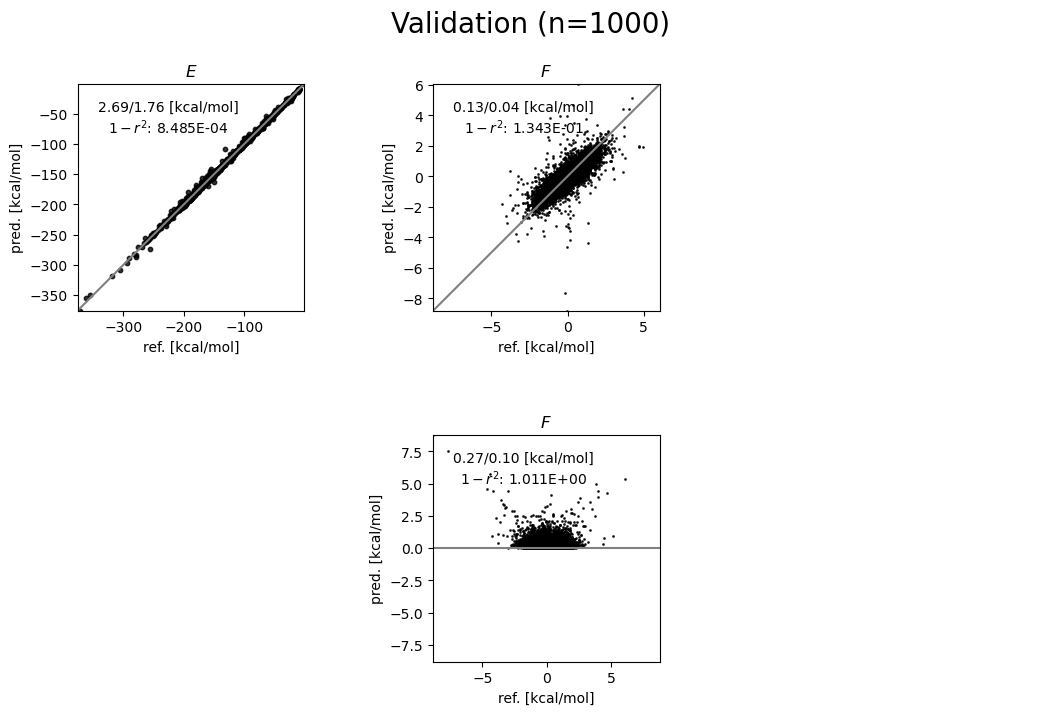

In [8]:

# for _ in test_batches[0].keys():
#     print(_, test_batches[0][_].shape)
    

# print(model)
output = plot_stats(validation_batches, model, params, _set="Validation", 
           do_kde=False, batch_size=batch_size)

In [9]:
list(output.keys())

['Es',
 'Eeles',
 'predEs',
 'Fs',
 'predFs',
 'Ds',
 'predDs',
 'charges',
 'outputs',
 'batches',
 'E_rmse',
 'E_mae',
 'F_rmse',
 'F_mae',
 'D_rmse',
 'D_mae',
 'n_params',
 'features',
 'max_degree',
 'num_iterations',
 'num_basis_functions',
 'cutoff',
 'max_atomic_number',
 'natoms',
 'total_charge',
 'n_res',
 'zbl',
 'debug',
 'efa']

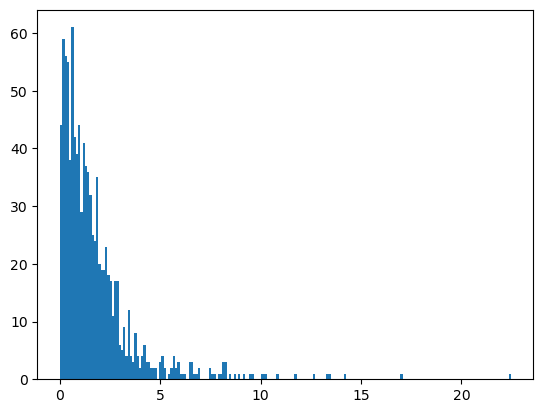

In [19]:
import numpy as np
import matplotlib.pyplot as plt

absolute_errors = np.abs((output["Es"] - output["predEs"]))

_ = plt.hist(absolute_errors, bins=200)

In [359]:
ds

spicev2

In [25]:
# sum(absolute_errors <= 1)/len(absolute_errors)

In [21]:
np.median(absolute_errors), absolute_errors.mean()

(np.float32(1.2153931), np.float32(1.7570395))

In [32]:
validation_set_idxs

array([1934105, 1668603, 1310867, 1543644, 1622365, 1603361,  870028,
        428546, 1896834,  304775, 1652334, 1988875,  684700, 1893732,
       1731805, 1476828, 1859741, 1847015,  344664, 1914271, 1516780,
       1495140, 1696022, 1758028, 1145176, 1243931,  846036,  317399,
       1401641, 1280188,  435958,  243295, 1527039,  666842,  668733,
       1358784,  893969, 1714825,  239845, 1545179, 1546524, 1773883,
        412882, 1083754, 1683343,   53148,  272715,  256057, 1631620,
        675164, 1370449, 1366899,  139210,  709482, 1536728, 1159880,
       1842953, 1240757, 1078438,  553210,  646888,  466583, 1251393,
        930733, 1347372, 1851159, 1807890,  307412,  769564, 1594402,
        822155, 1686270, 2005418, 1995480,  929874, 1410556,  839357,
       1382283, 1214146,  332080,  404633,  225095, 1078713, 1837444,
        121314,  534823,  561233, 1334896, 1129720,  555634, 1617486,
        504424,  426972, 1156672,  772321, 1614671, 1873163,    5489,
        865008,   96

In [341]:
val_idx = validation_set_idxs[11]

In [342]:
# output["Es"]

In [343]:
ds[val_idx]

{'positions': Array[66, 3] n=198 x∈[-9.034, 9.799] μ=8.429e-07 σ=4.425 gpu:0,
 'atomic_numbers': Array[66] i32 x∈[1, 8] μ=3.697 σ=3.362 gpu:0,
 'charges': Array[66] i32 x∈[-1, 0] μ=-0.030 σ=0.171 gpu:0,
 'e0': Array[66, 1] x∈[-2.046e+03, -13.572] μ=-782.751 σ=968.990 gpu:0,
 'energies': Array[1] gpu:0 [-1.907e+03],
 'formation_energies': Array[1] gpu:0 [4.975e+04],
 'per_atom_formation_energies': Array[1] gpu:0 [753.855],
 'name': np.str_('[O:1]=[C:5]([O-:3])[C:6](=[O:2])[O-:4].[O:7]([H:8])[H:9].[O:10]([H:11])[H:12].[O:13]([H:14])[H:15].[O:16]([H:17])[H:18].[O:19]([H:20])[H:21].[O:22]([H:23])[H:24].[O:25]([H:26])[H:27].[O:28]([H:29])[H:30].[O:31]([H:32])[H:33].[O:34]([H:35])[H:36].[O:37]([H:38])[H:39].[O:40]([H:41])[H:42].[O:43]([H:44])[H:45].[O:46]([H:47])[H:48].[O:49]([H:50])[H:51].[O:52]([H:53])[H:54].[O:55]([H:56])[H:57].[O:58]([H:59])[H:60].[O:61]([H:62])[H:63].[O:64]([H:65])[H:66]'),
 'subset': np.str_('Solvated PubChem'),
 'forces': Array[66, 3, 1] n=198 x∈[-0.074, 0.066] μ=6.80

In [358]:
ds[val_idx]["charges"].sum()

Array i32 gpu:0 -2

In [344]:
atoms = ds.get_ase_atoms(val_idx)

<bound method Atoms.get_charges of Atoms(symbols='C2H40O24', pbc=False, initial_charges=..., calculator=MessagePassingCalculator(...))>

In [345]:
# dir(atoms)
atoms.get_all_distances()
atoms.positions /= 1.88973

In [346]:
ds[val_idx]["e0"].sum()

Array gpu:0 -5.166e+04

In [347]:
ds[val_idx]["energies"].sum()

Array gpu:0 -1.907e+03

In [348]:
from ase.visualize import view

view(atoms, viewer="x3d")

In [349]:
atoms

Atoms(symbols='C2H40O24', pbc=False, initial_charges=..., calculator=Calculator(...))

In [350]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol
import e3x

In [351]:
model.natoms = len(atoms)

@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces", "dipole"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    output = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )

    # dipole = dipole_calc(atoms.get_positions(), 
    #                      atoms.get_atomic_numbers(), 
    #                      output["charges"],
    #             np.zeros_like(atoms.get_atomic_numbers()),
    #             1)
    self.results["dipole"] = 0 #dipole
    self.results['energy'] = output["energy"].squeeze() / (ase.units.kcal/ase.units.mol) #* ase.units.eV
    self.results['forces'] = output["forces"] / (ase.units.kcal/ase.units.mol) #* (ase.units.eV /ase.units.Angstrom)

In [352]:

atoms.calc  = MessagePassingCalculator()

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [353]:
atoms.get_potential_energy()

Array gpu:0 -205.907

In [354]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.01,steps=1000)
print()

      Step     Time          Energy          fmax
BFGS:    0 12:45:40     -205.906830        2.406702
BFGS:    1 12:45:40     -206.783936        2.003254
BFGS:    2 12:45:40     -210.015213        1.021017
BFGS:    3 12:45:40     -210.585388        1.259739
BFGS:    4 12:45:40     -211.607803        1.156469
BFGS:    5 12:45:41     -212.810120        0.996678
BFGS:    6 12:45:41     -213.287445        1.446209
BFGS:    7 12:45:41     -214.372833        1.362850
BFGS:    8 12:45:41     -215.307220        1.561228
BFGS:    9 12:45:41     -216.215515        1.994156
BFGS:   10 12:45:41     -217.087494        2.032113
BFGS:   11 12:45:41     -217.686234        2.119759
BFGS:   12 12:45:41     -218.435532        2.207183
BFGS:   13 12:45:41     -219.054688        1.930637
BFGS:   14 12:45:41     -219.505035        2.360694
BFGS:   15 12:45:41     -220.557419        1.649204
BFGS:   16 12:45:41     -221.602783        2.106881
BFGS:   17 12:45:41     -222.442291        1.734470
BFGS:   18 12:


KeyboardInterrupt



In [335]:
np.sum((atoms.positions[0] - atoms.positions[1])**2)**0.5

np.float64(2.3659642763804345)

In [336]:
print(atoms.get_dipole_moment())
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')
# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [337]:
# Parameters.
temperature = 300
timestep_fs = 0.1
num_steps = 10_00

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1 == 500:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

In [340]:
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': None, 'interval': 0.1})
# # view.show()

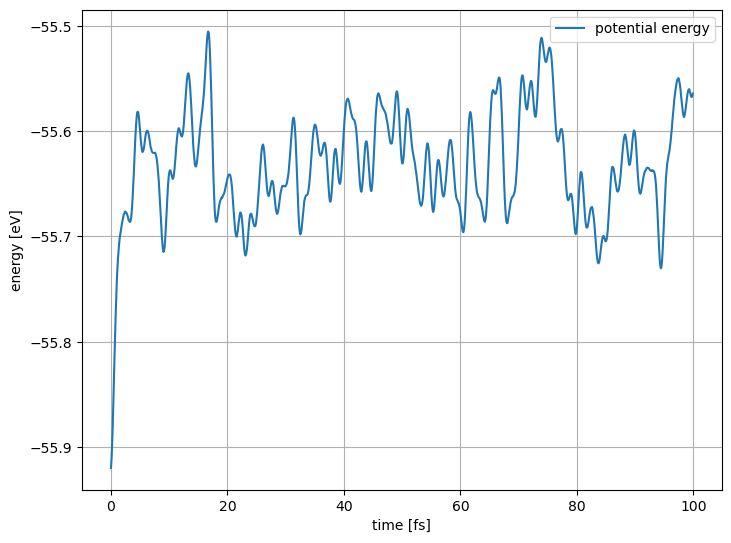

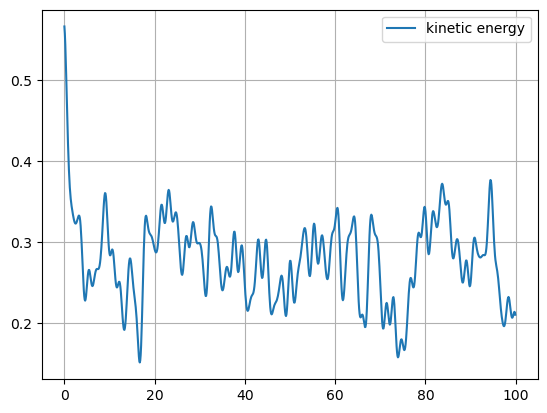

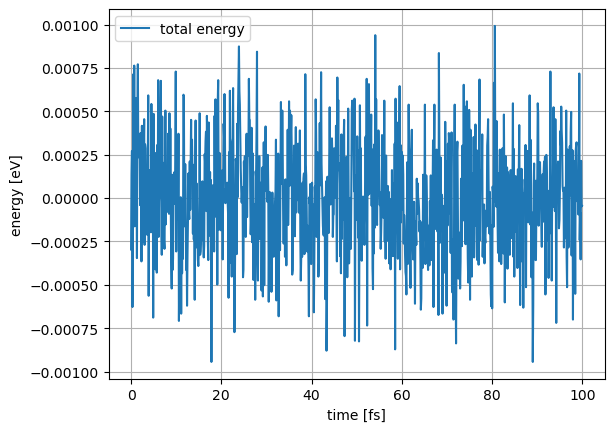

In [338]:
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, total_energy - total_energy.mean(), label='total energy')
plt.legend()
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
plt.grid()

In [ ]:
print("Model initialized")
print(batch_kwargs)

del ds

restart = None #"/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/test-7e4f020e-2810-4d75-802f-58797df3152a/epoch-64"


# Model training
params = train_model(
    train_key,
    model,
    training_set,
    validation_set,
    num_epochs=int(10**4),
    name="efa",
    learning_rate=0.001,
    energy_weight=1,
    #force_weight=1,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=BATCH_SIZE,
    num_atoms=NATOMS,
    data_keys=DATA_KEYS,
    print_freq=1,
    log_tb=False,
    #restart=restart,
    objective="valid_loss",
    best=1e6,
    batch_method="default",
#    batch_args_dict=batch_kwargs,
)